## Let's try hierarchy

### We'll see if a task comes it'll be as such:

### - CEO
#### - Research Team Leader -> Data Researcher or Market Researcher
#### - Writing Team Leader -> Technical Writer or Summary Writer

In [ ]:
import os
from typing import TypedDict, Annotated, List, Literal
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langchain_tavily import TavilySearch
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
import os
from dotenv import load_dotenv
import dspy
import operator
from mcp.server.fastmcp import FastMCP
from mcp.client.stdio import stdio_client
load_dotenv()

google_api_key = os.getenv("GOOGLE_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

os.environ["GOOGLE_API_KEY"] = google_api_key
os.environ["TAVILY_API_KEY"] = tavily_api_key 

langsmith_api_key = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_API_KEY"] = langsmith_api_key
os.environ["LANGSMITH_TRACING"] = "true" 
llm = init_chat_model("google_genai:gemini-2.0-flash")
llm

E0000 00:00:1760524335.251952   69810 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


ChatGoogleGenerativeAI(model='models/gemini-2.0-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x79383058c9b0>, default_metadata=(), model_kwargs={})

In [58]:
lm = dspy.LM("gemini/gemini-2.0-flash", api_key=google_api_key)
dspy.configure(lm=lm)

In [70]:
from mcp import ClientSession, StdioServerParameters
from mcp.client.stdio import stdio_client
import asyncio

# Global MCP sessions
mcp_sessions = {}

async def initialize_mcp_servers():
    """Initialize MCP server connections"""
    global mcp_sessions
    
    # Example: Connect to a web search MCP server
    search_server = StdioServerParameters(
        command="npx",
        args=["-y", "@modelcontextprotocol/server-brave-search"],
        env={"BRAVE_API_KEY": "your-api-key-here"}  # Set your API key
    )
    
    # Example: Connect to a filesystem MCP server for summaries
    # (you could create a custom MCP server for summarization)
    # For now, we'll keep summary local or use another MCP server
    
    # Connect to search server
    try:
        search_client = stdio_client(search_server)
        async with search_client as (read, write):
            async with ClientSession(read, write) as session:
                await session.initialize()
                mcp_sessions['search'] = session
                print("Connected to search MCP server")
    except Exception as e:
        print(f"Failed to connect to search MCP server: {e}")


In [71]:
async def search_web_mcp(query: str) -> str:
    """Search the web using MCP server"""
    try:
        session = mcp_sessions.get('search')
        if session:
            # Call the MCP tool
            result = await session.call_tool("brave_web_search", arguments={"query": query})
            return str(result.content)
        else:
            # Fallback if MCP not available
            return f"Search results for '{query}': [MCP server not connected, using fallback]"
    except Exception as e:
        return f"Search error: {str(e)}"

def search_web(query: str) -> str:
    """Synchronous wrapper for MCP search"""
    try:
        loop = asyncio.get_event_loop()
    except RuntimeError:
        loop = asyncio.new_event_loop()
        asyncio.set_event_loop(loop)
    
    return loop.run_until_complete(search_web_mcp(query))

def write_summary(content: str) -> str:
    """Write a concise summary of the content"""
    # This can be enhanced with an MCP server for summarization
    # Or use a local LLM call
    summary = f"Summary: {content[:500]}..."
    return summary

In [59]:
class CEORouting(dspy.Signature):
    """CEO agent routes incoming tasks to appropriate team leaders"""
    task: str = dspy.InputField(desc="The incoming task description")
    task_context: str = dspy.InputField(desc="Additional context about the task")
    team: Literal["research", "writing"] = dspy.OutputField(
        desc="Team to handle task: 'research' for data/market analysis, 'writing' for documentation/summaries"
    )
    reasoning: str = dspy.OutputField(desc="Justification for routing decision")
    refined_task: str = dspy.OutputField(desc="Clarified task description for the team")

In [60]:
class ResearchLeaderRouting(dspy.Signature):
    """Research Team Leader routes to data or market researcher"""
    task: str = dspy.InputField(desc="The research task from CEO")
    specialist: Literal["data_researcher", "market_researcher"] = dspy.OutputField(
        desc="'data_researcher' for data/statistics/trends, 'market_researcher' for market analysis/competitors"
    )
    reasoning: str = dspy.OutputField(desc="Why this specialist is best suited")
    specialist_instructions: str = dspy.OutputField(desc="Specific instructions for the specialist")

class WritingLeaderRouting(dspy.Signature):
    """Writing Team Leader routes to technical or summary writer"""
    task: str = dspy.InputField(desc="The writing task from CEO")
    content: str = dspy.InputField(desc="Source content to work with")
    specialist: Literal["technical_writer", "summary_writer"] = dspy.OutputField(
        desc="'technical_writer' for docs/guides, 'summary_writer' for concise summaries"
    )
    reasoning: str = dspy.OutputField(desc="Why this specialist is best suited")
    specialist_instructions: str = dspy.OutputField(desc="Specific instructions for the specialist")

In [61]:
class DataResearchExecution(dspy.Signature):
    """Data Researcher executes data-focused research"""
    task: str = dspy.InputField(desc="The data research task")
    instruction: str = dspy.InputField(desc="Specific instructions from team leader")
    search_queries: List[str] = dspy.OutputField(desc="Optimized search queries (2-3 queries)")
    analysis: str = dspy.OutputField(desc="Analysis framework for the data")

class MarketResearchExecution(dspy.Signature):
    """Market Researcher executes market analysis"""
    task: str = dspy.InputField(desc="The market research task")
    instruction: str = dspy.InputField(desc="Specific instructions from team leader")
    search_queries: List[str] = dspy.OutputField(desc="Optimized search queries (2-3 queries)")
    analysis: str = dspy.OutputField(desc="Market analysis framework")

In [62]:
class TechnicalWritingExecution(dspy.Signature):
    """Technical Writer creates documentation"""
    task = dspy.InputField(desc="The technical writing task")
    instruction = dspy.InputField(desc="Specific instructions from team leader")
    content = dspy.InputField(desc="Source content")
    document = dspy.OutputField(desc="Technical documentation output")

class SummaryWritingExecution(dspy.Signature):
    """Summary Writer creates concise summaries"""
    task = dspy.InputField(desc="The summary writing task")
    instruction = dspy.InputField(desc="Specific instructions from team leader")
    content = dspy.InputField(desc="Content to summarize")
    summary = dspy.OutputField(desc="Concise summary output")

In [63]:
class CEOAgent(dspy.Module):
    def __init__(self):
        super().__init__()
        self.route = dspy.ChainOfThought(CEORouting)
    
    def forward(self, task, task_context=""):
        return self.route(task=task, task_context=task_context)

class ResearchLeader(dspy.Module):
    def __init__(self):
        super().__init__()
        self.route = dspy.ChainOfThought(ResearchLeaderRouting)
    
    def forward(self, task):
        return self.route(task=task)

class WritingLeader(dspy.Module):
    def __init__(self):
        super().__init__()
        self.route = dspy.ChainOfThought(WritingLeaderRouting)
    
    def forward(self, task, content):
        return self.route(task=task, content=content)

class DataResearcher(dspy.Module):
    def __init__(self):
        super().__init__()
        self.execute = dspy.ChainOfThought(DataResearchExecution)
    
    def forward(self, task, instructions):
        return self.execute(task=task, instructions=instructions)

class MarketResearcher(dspy.Module):
    def __init__(self):
        super().__init__()
        self.execute = dspy.ChainOfThought(MarketResearchExecution)
    
    def forward(self, task, instructions):
        return self.execute(task=task, instructions=instructions)

class TechnicalWriter(dspy.Module):
    def __init__(self):
        super().__init__()
        self.execute = dspy.ChainOfThought(TechnicalWritingExecution)
    
    def forward(self, task, instructions, content):
        return self.execute(task=task, instructions=instructions, content=content)

class SummaryWriter(dspy.Module):
    def __init__(self):
        super().__init__()
        self.execute = dspy.ChainOfThought(SummaryWritingExecution)
    
    def forward(self, task, instructions, content):
        return self.execute(task=task, instructions=instructions, content=content)


In [64]:
class WorkflowState(TypedDict):
    task: str
    task_context: str
    team: str
    specialist: str
    reasoning: Annotated[List[str], operator.add]
    refined_task: str
    specialist_instructions: str
    search_queries: List[str]
    search_results: List[str]
    content: str
    final_output: str

ceo = CEOAgent()
research_leader = ResearchLeader()
writing_leader = WritingLeader()
data_researcher = DataResearcher()
market_researcher = MarketResearcher()
technical_writer = TechnicalWriter()
summary_writer = SummaryWriter()

In [ ]:
def ceo_node(state: WorkflowState) -> WorkflowState:
    """CEO routes the task to appropriate team"""
    result = ceo(task=state["task"], task_context=state.get("task_context", ""))
    
    return {
        **state,
        "team": result.team,
        "refined_task": result.refined_task,
        "reasoning": [f"CEO: {result.reasoning}"]
    }

def research_leader_node(state: WorkflowState) -> WorkflowState:
    """Research Team Leader routes to specialist"""
    result = research_leader(task=state["refined_task"])
    
    return {
        **state,
        "specialist": result.specialist,
        "specialist_instructions": result.specialist_instructions,
        "reasoning": [f"Research Leader: {result.reasoning}"]
    }

def writing_leader_node(state: WorkflowState) -> WorkflowState:
    """Writing Team Leader routes to specialist"""
    content = state.get("content", "")
    result = writing_leader(task=state["refined_task"], content=content)
    
    return {
        **state,
        "specialist": result.specialist,
        "specialist_instructions": result.specialist_instructions,
        "reasoning": [f"Writing Leader: {result.reasoning}"]
    }

def data_researcher_node(state: WorkflowState) -> WorkflowState:
    """Data Researcher executes research"""
    result = data_researcher(
        task=state["refined_task"],
        instructions=state["specialist_instructions"]
    )
    
    # Execute searches
    search_results = []
    for query in result.search_queries:
        search_results.append(search_web(query))
    
    final_output = f"Data Research Analysis:\n{result.analysis}\n\nFindings:\n" + "\n".join(search_results)
    
    return {
        **state,
        "search_queries": result.search_queries,
        "search_results": search_results,
        "final_output": final_output
    }

def market_researcher_node(state: WorkflowState) -> WorkflowState:
    """Market Researcher executes research"""
    result = market_researcher(
        task=state["refined_task"],
        instructions=state["specialist_instructions"]
    )
    
    # Execute searches
    search_results = []
    for query in result.search_queries:
        search_results.append(search_web(query))
    
    final_output = f"Market Research Analysis:\n{result.analysis}\n\nFindings:\n" + "\n".join(search_results)
    
    return {
        **state,
        "search_queries": result.search_queries,
        "search_results": search_results,
        "final_output": final_output
    }

def technical_writer_node(state: WorkflowState) -> WorkflowState:
    """Technical Writer creates documentation"""
    content = state.get("content", "")
    result = technical_writer(
        task=state["refined_task"],
        instructions=state["specialist_instructions"],
        content=content
    )
    
    return {
        **state,
        "final_output": result.document
    }

def summary_writer_node(state: WorkflowState) -> WorkflowState:
    """Summary Writer creates summary"""
    content = state.get("content", "")
    result = summary_writer(
        task=state["refined_task"],
        instructions=state["specialist_instructions"],
        content=content
    )
    
    # Also use the tool
    tool_summary = write_summary(content)
    
    return {
        **state,
        "final_output": f"{result.summary}\n\nTool Summary: {tool_summary}"
    }


In [66]:
def route_from_ceo(state: WorkflowState) -> str:
    """Route from CEO to team leaders"""
    if state["team"] == "research":
        return "research_leader"
    else:
        return "writing_leader"

def route_from_research_leader(state: WorkflowState) -> str:
    """Route from Research Leader to specialists"""
    if state["specialist"] == "data_researcher":
        return "data_researcher"
    else:
        return "market_researcher"

def route_from_writing_leader(state: WorkflowState) -> str:
    """Route from Writing Leader to specialists"""
    if state["specialist"] == "technical_writer":
        return "technical_writer"
    else:
        return "summary_writer"

In [67]:
def build_workflow():
    """Build the hierarchical agent workflow"""
    workflow = StateGraph(WorkflowState)
    
    # Add nodes
    workflow.add_node("ceo", ceo_node)
    workflow.add_node("research_leader", research_leader_node)
    workflow.add_node("writing_leader", writing_leader_node)
    workflow.add_node("data_researcher", data_researcher_node)
    workflow.add_node("market_researcher", market_researcher_node)
    workflow.add_node("technical_writer", technical_writer_node)
    workflow.add_node("summary_writer", summary_writer_node)
    
    # Set entry point
    workflow.set_entry_point("ceo")
    
    # Add conditional edges
    workflow.add_conditional_edges(
        "ceo",
        route_from_ceo,
        {
            "research_leader": "research_leader",
            "writing_leader": "writing_leader"
        }
    )
    
    workflow.add_conditional_edges(
        "research_leader",
        route_from_research_leader,
        {
            "data_researcher": "data_researcher",
            "market_researcher": "market_researcher"
        }
    )
    
    workflow.add_conditional_edges(
        "writing_leader",
        route_from_writing_leader,
        {
            "technical_writer": "technical_writer",
            "summary_writer": "summary_writer"
        }
    )
    
    # All specialists end the workflow
    workflow.add_edge("data_researcher", END)
    workflow.add_edge("market_researcher", END)
    workflow.add_edge("technical_writer", END)
    workflow.add_edge("summary_writer", END)
    
    return workflow.compile()

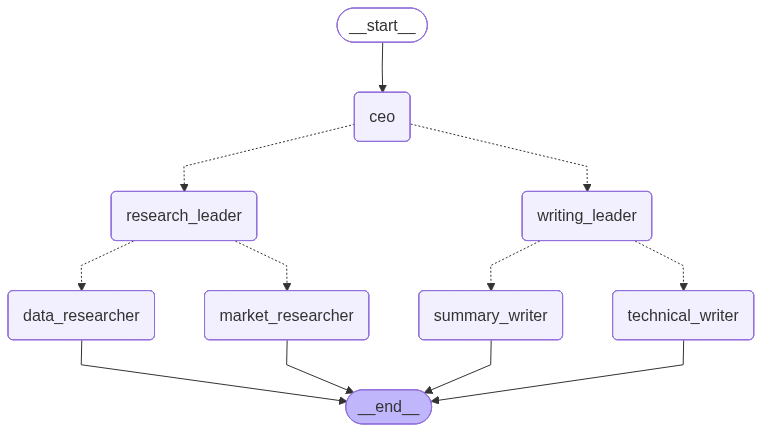

In [68]:
app = build_workflow()
app

### Let's try a research task

In [69]:
from mcp_client import initialize_mcp
initialize_mcp()
client = SimpleMCPClient()
await client.connect()

print("=" * 80)
print("EXAMPLE 1: Research Task")
print("=" * 80)

result1 = app.invoke({
    "task": "Analyze the current trends in AI agent frameworks",
    "task_context": "We need this for a strategic planning meeting",
    "reasoning": [],
    "content": ""
})

print(f"\nTask: {result1['task']}")
print(f"Team: {result1['team']}")
print(f"Specialist: {result1['specialist']}")
print(f"\nReasoning Chain:")
for r in result1['reasoning']:
    print(f"  - {r}")
print(f"\nFinal Output:\n{result1['final_output']}")

✓ Connected to summary_writing MCP server


2025/10/15 15:32:18 WARNING dspy.predict.predict: Not all input fields were provided to module. Present: ['task']. Missing: ['instruction'].


✓ Connected to web_search MCP server
EXAMPLE 1: Research Task


TypeError: sequence item 0: expected str instance, coroutine found

### Now a writing task

In [ ]:
# Example 2: Writing task
print("\n" + "=" * 80)
print("EXAMPLE 2: Writing Task")
print("=" * 80)

result2 = app.invoke({
    "task": "Create documentation for our new API endpoint",
    "task_context": "Technical documentation for developers",
    "content": "POST /api/users - Creates a new user with email and password",
    "reasoning": []
})

print(f"\nTask: {result2['task']}")
print(f"Team: {result2['team']}")
print(f"Specialist: {result2['specialist']}")
print(f"\nReasoning Chain:")
for r in result2['reasoning']:
    print(f"  - {r}")
print(f"\nFinal Output:\n{result2['final_output']}")


EXAMPLE 2: Writing Task


2025/10/15 12:28:37 WARNING dspy.predict.predict: Not all input fields were provided to module. Present: ['task', 'content']. Missing: ['instruction'].



Task: Create documentation for our new API endpoint
Team: writing
Specialist: technical_writer

Reasoning Chain:
  - CEO: The task involves creating documentation, which falls under the purview of the writing team. The context specifies technical documentation, further solidifying this decision.
  - Writing Leader: The task requires creating technical documentation for a new API endpoint. This includes details like parameter descriptions, example usage, and error codes, which falls under the purview of a technical writer.
  - CEO: The task involves creating documentation, which falls under the purview of the writing team. The context specifies technical documentation, further solidifying this decision.
  - Writing Leader: The task requires creating technical documentation for a new API endpoint. This includes details like parameter descriptions, example usage, and error codes, which falls under the purview of a technical writer.

Final Output:
# POST /api/users

Creates a new user.

#